# Problem Set 5
In this problem set you will implement the Conditional Gradient algorithm, also known as the Frank Wolfe algorithm, and you will compare it to algiorithms you have implemented on previous homeworks. You will also play with Mirror Descent.

In [5]:
import numpy as np
import numpy.random as rn
import numpy.linalg as la
import matplotlib.pyplot as plt
import time

# ============================================================================
# FILE UPLOAD SECTION (for Google Colab)
# ============================================================================
print("=" * 60)
print("FILE UPLOAD FOR GOOGLE COLAB")
print("=" * 60)

from google.colab import files

print("\n=== Problem 1: LASSO via Frank-Wolfe ===")
print("Please upload A.npy and b.npy")
uploaded_1 = files.upload()

# Load Problem 1 data
A = np.load("A.npy")
b = np.load("b.npy")
print(f"✓ Loaded A: shape {A.shape}")
print(f"✓ Loaded b: shape {b.shape}")

print("\n=== Problem 2: Robust Regression ===")
print("Please upload X.npy and y.npy")
uploaded_2 = files.upload()

# Load Problem 2 data
X = np.load("X.npy")
y = np.load("y.npy")
print(f"✓ Loaded X: shape {X.shape}")
print(f"✓ Loaded y: shape {y.shape}")

print("\n" + "=" * 60)
print("All files loaded successfully!")
print("=" * 60 + "\n")

FILE UPLOAD FOR GOOGLE COLAB

=== Problem 1: LASSO via Frank-Wolfe ===
Please upload A.npy and b.npy


Saving A.npy to A (1).npy
Saving b.npy to b (1).npy
✓ Loaded A: shape (442, 100)
✓ Loaded b: shape (442,)

=== Problem 2: Robust Regression ===
Please upload X.npy and y.npy


Saving X.npy to X (1).npy
Saving y.npy to y (1).npy
✓ Loaded X: shape (1000, 20)
✓ Loaded y: shape (1000,)

All files loaded successfully!



# Problem 1: LASSO via Frank Wolfe
Recall the least squares problem with $\ell^1$ regularization from the previous two homeworks:
$$
\min_x \left[f(x) = \frac{1}{2}\|{Ax-b}\|_2^2 + \lambda \|{x}\|_1 \right]
$$

So far you have used the subgradient method, ISTA and FISTA (proxima gradient, and accelerated proximal gradient) to solve this problem. Now you will use Frank-Wolfe.

As we cover in the lectures, the Frank-Wolfe (or conditional gradient) algorithm minimizes a smooth function $f(x)$ subject to a convex constraint $x \in \mathcal{X}$.

When it is easy to minimize a linear function over $\mathcal{X}$, Frank-Wolfe (FW) has several advantages including that it often produces sparse iterates and does not require a projection step to stay within $\mathcal{X}$. In order to apply FW to the LASSO problem above, we can reformulate the problem as

\begin{eqnarray*}
\min_{{x}}: && \frac{1}{2}\|A{x}-{b}\|_2^2, \\
\mbox{s.t. } && \|{x}\|_1 \leq \gamma.
\end{eqnarray*}

This formulation is equivalent to the original LASSO formulation for a suitable value of $\gamma$ (and depending on the $\lambda$ in the original LASSO formulation).

Run the FW algorithm for $10^4$ steps and find a $\gamma$ that performs well empirically (you might consider the $\ell^1$ norm of your solution from previous homework. Compare the results to sub-gradient method implemented in the previous homework. Again, separately record the (unsquared) error $\|A{x}_t-{b}\|$ and the regularization term $\|{x}\|_1$.


PROBLEM 1: LASSO VIA FRANK-WOLFE

Running Frank-Wolfe...
Iteration 1000: Error = 13.1791, L1-norm = 3.7510
Iteration 2000: Error = 13.1211, L1-norm = 4.1973
Iteration 3000: Error = 13.1039, L1-norm = 4.4792
Iteration 4000: Error = 13.1011, L1-norm = 4.5338
Iteration 5000: Error = 13.0989, L1-norm = 4.5975
Iteration 6000: Error = 13.0980, L1-norm = 4.6295
Iteration 7000: Error = 13.0973, L1-norm = 4.6560
Iteration 8000: Error = 13.0964, L1-norm = 4.7126
Iteration 9000: Error = 13.0962, L1-norm = 4.7322
Iteration 10000: Error = 13.0960, L1-norm = 4.7393

Frank-Wolfe Results:
Final error: 13.0960
Final L1-norm: 4.7393
Final objective: 85.7525

Running Subgradient method...
Iteration 1000: Error = 13.1388, L1-norm = 3.9256
Iteration 2000: Error = 13.1327, L1-norm = 3.9639
Iteration 3000: Error = 13.1287, L1-norm = 4.0031
Iteration 4000: Error = 13.1258, L1-norm = 4.0341
Iteration 5000: Error = 13.1234, L1-norm = 4.0601
Iteration 6000: Error = 13.1214, L1-norm = 4.0826
Iteration 7000: Erro

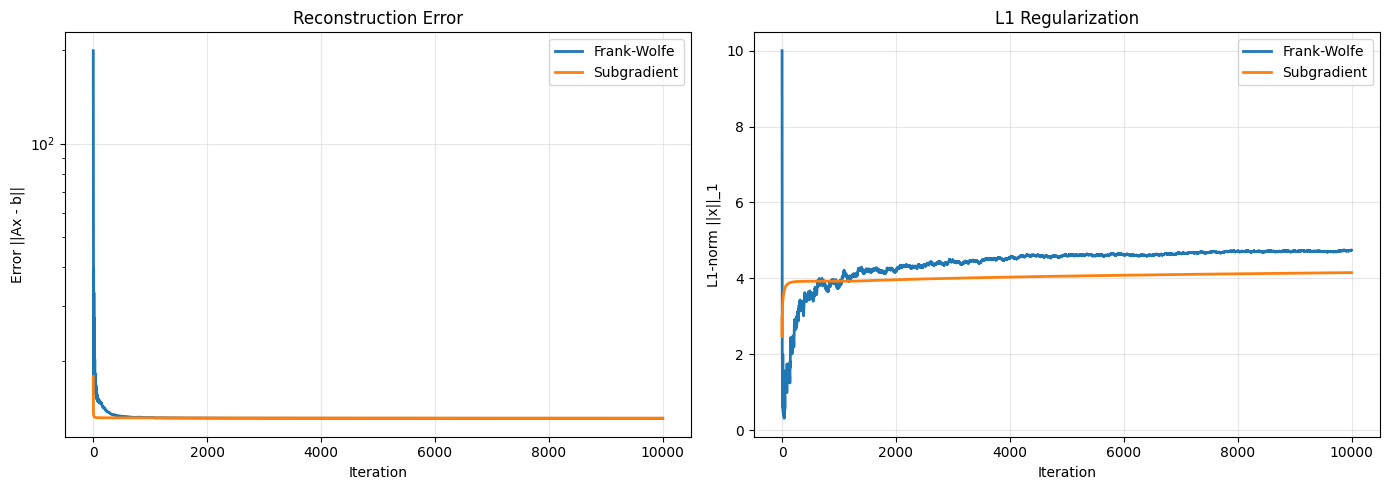


✓ Problem 1 plot saved as 'problem1_comparison.png'


In [6]:


print("\n" + "=" * 60)
print("PROBLEM 1: LASSO VIA FRANK-WOLFE")
print("=" * 60)

def frank_wolfe_lasso(A, b, gamma, max_iters=10000):
    """
    Frank-Wolfe algorithm for LASSO:
    min_{x} 1/2 ||Ax - b||^2  s.t. ||x||_1 <= gamma

    Parameters:
    -----------
    A : array, shape (m, n)
    b : array, shape (m,)
    gamma : float, l1-norm constraint
    max_iters : int, number of iterations

    Returns:
    --------
    x : final solution
    errors : list of ||Ax - b|| values
    l1_norms : list of ||x||_1 values
    objectives : list of objective function values
    """
    m, n = A.shape
    x = np.zeros(n)  # Initialize at origin

    errors = []
    l1_norms = []
    objectives = []

    # Precompute A^T A and A^T b for efficiency
    AtA = A.T @ A
    Atb = A.T @ b

    for t in range(max_iters):
        # Compute gradient: nabla f(x) = A^T(Ax - b)
        grad = AtA @ x - Atb

        # Linear minimization oracle: min_{s: ||s||_1 <= gamma} <grad, s>
        # Solution: s = -gamma * sign(grad[i_max]) * e_{i_max}
        # where i_max = argmax |grad_i|
        i_max = np.argmax(np.abs(grad))
        s = np.zeros(n)
        s[i_max] = -gamma * np.sign(grad[i_max])

        # Step size: using line search or 2/(t+2) rule
        step_size = 2.0 / (t + 2)

        # Update: x_{t+1} = (1 - step_size) * x_t + step_size * s
        x = (1 - step_size) * x + step_size * s

        # Record metrics
        residual = A @ x - b
        error = la.norm(residual)
        l1_norm = la.norm(x, 1)
        objective = 0.5 * error**2

        errors.append(error)
        l1_norms.append(l1_norm)
        objectives.append(objective)

        if (t + 1) % 1000 == 0:
            print(f"Iteration {t+1}: Error = {error:.4f}, L1-norm = {l1_norm:.4f}")

    return x, errors, l1_norms, objectives


def subgradient_lasso(A, b, lambda_reg, max_iters=10000, step_size=0.001):
    """
    Subgradient method for LASSO:
    min_{x} 1/2 ||Ax - b||^2 + lambda ||x||_1

    Parameters:
    -----------
    A : array, shape (m, n)
    b : array, shape (m,)
    lambda_reg : float, regularization parameter
    max_iters : int, number of iterations
    step_size : float, step size

    Returns:
    --------
    x : final solution
    errors : list of ||Ax - b|| values
    l1_norms : list of ||x||_1 values
    objectives : list of objective function values
    """
    m, n = A.shape
    x = np.zeros(n)

    errors = []
    l1_norms = []
    objectives = []

    AtA = A.T @ A
    Atb = A.T @ b

    for t in range(max_iters):
        # Gradient of smooth part: A^T(Ax - b)
        grad_smooth = AtA @ x - Atb

        # Subgradient of ||x||_1
        subgrad_l1 = np.sign(x)
        subgrad_l1[x == 0] = 0  # Can be any value in [-1, 1]

        # Full subgradient
        subgrad = grad_smooth + lambda_reg * subgrad_l1

        # Update with decreasing step size
        alpha = step_size / np.sqrt(t + 1)
        x = x - alpha * subgrad

        # Record metrics
        residual = A @ x - b
        error = la.norm(residual)
        l1_norm = la.norm(x, 1)
        objective = 0.5 * error**2 + lambda_reg * l1_norm

        errors.append(error)
        l1_norms.append(l1_norm)
        objectives.append(objective)

        if (t + 1) % 1000 == 0:
            print(f"Iteration {t+1}: Error = {error:.4f}, L1-norm = {l1_norm:.4f}")

    return x, errors, l1_norms, objectives


# Run Frank-Wolfe
print("\nRunning Frank-Wolfe...")
gamma = 10.0  # You may need to tune this
x_fw, errors_fw, l1_norms_fw, objectives_fw = frank_wolfe_lasso(A, b, gamma, max_iters=10000)

print(f"\nFrank-Wolfe Results:")
print(f"Final error: {errors_fw[-1]:.4f}")
print(f"Final L1-norm: {l1_norms_fw[-1]:.4f}")
print(f"Final objective: {objectives_fw[-1]:.4f}")

# Run Subgradient method for comparison
print("\nRunning Subgradient method...")
lambda_reg = 0.1  # Regularization parameter
x_sg, errors_sg, l1_norms_sg, objectives_sg = subgradient_lasso(A, b, lambda_reg, max_iters=10000)

print(f"\nSubgradient Results:")
print(f"Final error: {errors_sg[-1]:.4f}")
print(f"Final L1-norm: {l1_norms_sg[-1]:.4f}")
print(f"Final objective: {objectives_sg[-1]:.4f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot error
axes[0].semilogy(errors_fw, label='Frank-Wolfe', linewidth=2)
axes[0].semilogy(errors_sg, label='Subgradient', linewidth=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Error ||Ax - b||')
axes[0].set_title('Reconstruction Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot L1-norm
axes[1].plot(l1_norms_fw, label='Frank-Wolfe', linewidth=2)
axes[1].plot(l1_norms_sg, label='Subgradient', linewidth=2)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('L1-norm ||x||_1')
axes[1].set_title('L1 Regularization')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('problem1_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Problem 1 plot saved as 'problem1_comparison.png'")

#Problem 2: Robust Regression, PSGD and Mirror Descent
Consider the problem of robust regression, where some small number of measurements have been potentially completely corrupted. One way to formulate an optimization problem to solve this robust regression is as follows:

\begin{eqnarray*}
\min_{\beta}: && \|X \beta - \mathbf{y}\|_1 \\
{\rm s.t.}: && \beta \in \mathcal{X}.
\end{eqnarray*}

The rationale for this formulation stems from the idea that because of the $\ell^1$-error, huge errors are not disproportionally penalized, as they would be in the squared error formulation (this is the formulation we have worked with before, including in the previous problem), and therefore the optimal solution is less sensitive to outliers. You will solve this problem using Projected Subgradient Descent, and also Mirror Descent. Let the constraint set be the simplex:
$$
\mathfrak{X} = \{\beta \,:\, \beta \geq 0, \, \sum \beta_i = 1\}.
$$





##Part (A)
Write down the update for projected gradient descent.

The projected subgradient descent algorithm iteratively updates β as follows:

UPDATE RULE:
-----------
β^(t+1) = Π_𝔛[β^(t) - αₜ · g^(t)]

where:
- αₜ is the step size at iteration t
- g^(t) ∈ ∂f(β^(t)) is a subgradient of f at β^(t)
- Π_𝔛[·] is the projection operator onto the simplex 𝔛

SUBGRADIENT COMPUTATION:
-----------------------
For f(β) = ||Xβ - y||₁ = Σᵢ |[Xβ - y]ᵢ|

A subgradient is:
g = X^T · sign(Xβ - y)

where sign(z) = {  1  if z > 0
                {  0  if z = 0  (can be any value in [-1,1])
                { -1  if z < 0

PROJECTION ONTO SIMPLEX:
------------------------
The projection Π_𝔛[v] solves:
    minimize   ||w - v||₂²
    subject to w ≥ 0, Σᵢ wᵢ = 1

This can be solved efficiently using:
1. Sort v in descending order to get u
2. Find ρ = max{j : uⱼ - (1/(j+1))(Σᵢ₌₀ʲ uᵢ - 1) > 0}
3. Set θ = (1/(ρ+1))(Σᵢ₌₀ᵖ uᵢ - 1)
4. Return w = max(v - θ, 0)

COMPLETE ALGORITHM:
-------------------
1. Initialize β^(0) ∈ 𝔛 (e.g., uniform distribution: βᵢ = 1/n)
2. For t = 0, 1, 2, ...
   a. Compute residual: r = Xβ^(t) - y
   b. Compute subgradient: g^(t) = X^T · sign(r)
   c. Take gradient step: β̃ = β^(t) - αₜ · g^(t)
   d. Project back: β^(t+1) = Π_𝔛[β̃]

##Part (B)
Write down the mirror descent update. For this, we will use the mirror map $\Phi(\beta) = \sum \beta_i \log \beta_i$. Compute the Bregman divergence, $D_{\phi}(\mathbf{\beta},\mathbf{z})$ explicitly. <br>
(We use $\mathbf{z}$ here to not confuse this variable with $\mathbf{y}$ in the robust regression problem above. $\mathbf{z}$ is the intermediate term used in Mirror Descent, which was commonly denoted as $\mathbf{y}$ in the lectures.)

MIRROR MAP:
-----------
We use the entropic (negative entropy) mirror map:
Φ(β) = Σᵢ βᵢ log(βᵢ)

The gradient is:
∇Φ(β) = [log(β₁) + 1, log(β₂) + 1, ..., log(βₙ) + 1]^T

BREGMAN DIVERGENCE:
-------------------
The Bregman divergence associated with Φ is:

D_Φ(β, z) = Φ(β) - Φ(z) - ⟨∇Φ(z), β - z⟩

EXPLICIT COMPUTATION:
D_Φ(β, z) = Σᵢ βᵢ log(βᵢ) - Σᵢ zᵢ log(zᵢ) - Σᵢ (log(zᵢ) + 1)(βᵢ - zᵢ)

          = Σᵢ βᵢ log(βᵢ) - Σᵢ zᵢ log(zᵢ) - Σᵢ (βᵢ log(zᵢ) - zᵢ log(zᵢ) + βᵢ - zᵢ)

          = Σᵢ βᵢ log(βᵢ) - Σᵢ βᵢ log(zᵢ) - Σᵢ βᵢ + Σᵢ zᵢ

          = Σᵢ βᵢ log(βᵢ/zᵢ) - Σᵢ βᵢ + Σᵢ zᵢ

Since β and z are on the simplex (Σᵢ βᵢ = Σᵢ zᵢ = 1):

D_Φ(β, z) = Σᵢ βᵢ log(βᵢ/zᵢ) - 1 + 1

          = Σᵢ βᵢ log(βᵢ/zᵢ)

          = KL(β || z)  (KL divergence from β to z)

FINAL FORM:
-----------
D_Φ(β, z) = KL(β || z) = Σᵢ βᵢ log(βᵢ/zᵢ)


MIRROR DESCENT UPDATE:
----------------------
The mirror descent algorithm consists of two steps:

Step 1: Mirror gradient step (in dual space)
z^(t+1) = argmin_z { ⟨g^(t), z⟩ + (1/αₜ) D_Φ(z, β^(t)) }

where g^(t) is a subgradient of f at β^(t).

Step 2: Mirror map (back to primal space)
β^(t+1) = ∇Φ*(∇Φ(β^(t)) - αₜ g^(t))

For the entropic mirror map on the simplex, this simplifies to:

EXPLICIT UPDATE FORMULA:
z^(t+1) = β^(t) ⊙ exp(-αₜ g^(t)) / Z

where:
- ⊙ denotes element-wise multiplication
- exp is applied element-wise
- Z = Σᵢ βᵢ^(t) exp(-αₜ gᵢ^(t)) is the normalization constant

Then β^(t+1) = z^(t+1)

DERIVATION OF EXPLICIT UPDATE:
-------------------------------
The update z^(t+1) = argmin_z { ⟨g^(t), z⟩ + (1/αₜ) KL(z || β^(t)) }

Setting the gradient to zero:
g^(t) + (1/αₜ)(log(z) + 1 - log(β^(t)) - 1) = 0
g^(t) + (1/αₜ) log(z/β^(t)) = 0
log(z/β^(t)) = -αₜ g^(t)
z/β^(t) = exp(-αₜ g^(t))
z = β^(t) ⊙ exp(-αₜ g^(t))

Normalizing to ensure Σᵢ zᵢ = 1:
z^(t+1) = β^(t) ⊙ exp(-αₜ g^(t)) / (Σⱼ βⱼ^(t) exp(-αₜ gⱼ^(t)))

COMPLETE ALGORITHM:
-------------------
1. Initialize β^(0) ∈ 𝔛 (e.g., uniform: βᵢ = 1/n)
2. For t = 0, 1, 2, ...
   a. Compute subgradient: g^(t) = X^T · sign(Xβ^(t) - y)
   b. Update in log-space:
      log(β^(t+1)) = log(β^(t)) - αₜ g^(t) - log(Z)
      where Z = Σⱼ exp(log(βⱼ^(t)) - αₜ gⱼ^(t))
   c. Equivalently: β^(t+1) = β^(t) ⊙ exp(-αₜ g^(t)) / Z

##Part (C)
Using the data in X.npy and y.npy, and using stepsizes of your choosing, compare the projected subgradient method with mirror descent. What is $\beta$? Plot the objective above against iterations for both methods (in a single plot).


PROBLEM 2: ROBUST REGRESSION - PSGD AND MIRROR DESCENT

Running Projected Subgradient Descent...
PSGD Iteration 100: Objective = 107.7685
PSGD Iteration 200: Objective = 90.3682
PSGD Iteration 300: Objective = 82.2751
PSGD Iteration 400: Objective = 75.6148
PSGD Iteration 500: Objective = 69.6312
PSGD Iteration 600: Objective = 62.4364
PSGD Iteration 700: Objective = 60.1707
PSGD Iteration 800: Objective = 56.8393
PSGD Iteration 900: Objective = 56.4627
PSGD Iteration 1000: Objective = 52.8286

PSGD Results:
Final objective: 52.8286
Beta sum: 1.000000 (should be 1.0)
Beta min: 0.000000 (should be >= 0)
Number of non-zero entries: 13

Running Mirror Descent...
Mirror Descent Iteration 100: Objective = 44.1208
Mirror Descent Iteration 200: Objective = 53.6206
Mirror Descent Iteration 300: Objective = 45.4490
Mirror Descent Iteration 400: Objective = 37.3099
Mirror Descent Iteration 500: Objective = 34.1769
Mirror Descent Iteration 600: Objective = 36.0480
Mirror Descent Iteration 700: O

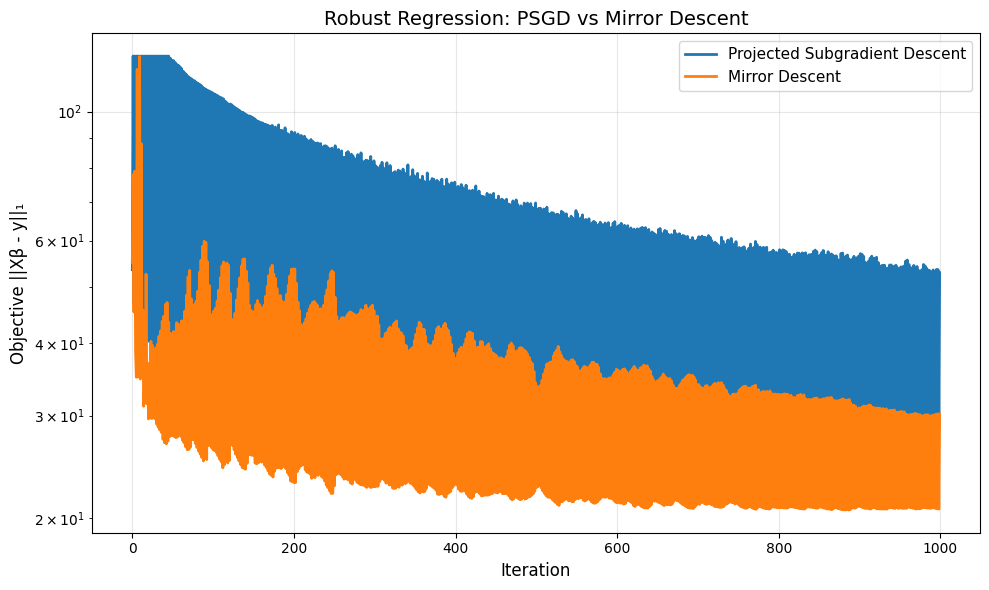


✓ Problem 2 plot saved as 'problem2_comparison.png'

Final β (first 10 components):
PSGD: [0.30956579 0.04390023 0.05445306 0.06133948 0.11393415 0.05797269
 0.         0.04109503 0.08835321 0.        ]
Mirror Descent: [0.14468464 0.04996386 0.0532626  0.05588004 0.04783172 0.04414449
 0.02930053 0.06343571 0.09139291 0.02571321]


In [7]:
print("\n" + "=" * 60)
print("PROBLEM 2: ROBUST REGRESSION - PSGD AND MIRROR DESCENT")
print("=" * 60)

def project_simplex(v):
    """
    Project vector v onto the probability simplex.
    Uses efficient O(n log n) algorithm.

    Parameters:
    -----------
    v : array, shape (n,)

    Returns:
    --------
    w : array, shape (n,), projection onto simplex
    """
    n = len(v)
    u = np.sort(v)[::-1]  # Sort in descending order
    cssv = np.cumsum(u)
    rho = np.where(u * np.arange(1, n+1) > (cssv - 1))[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    w = np.maximum(v - theta, 0)
    return w


def subgradient_l1_loss(X, beta, y):
    """
    Compute a subgradient of ||X beta - y||_1

    Parameters:
    -----------
    X : array, shape (m, n)
    beta : array, shape (n,)
    y : array, shape (m,)

    Returns:
    --------
    subgrad : array, shape (n,)
    """
    residual = X @ beta - y
    # Subgradient is X^T * sign(residual)
    # At zeros, we can choose any value in [-1, 1]; we use 0
    subgrad = X.T @ np.sign(residual)
    return subgrad


def projected_subgradient_descent(X, y, max_iters=1000, step_size=0.01):
    """
    Projected Subgradient Descent for:
    min_{beta in simplex} ||X beta - y||_1

    Parameters:
    -----------
    X : array, shape (m, n)
    y : array, shape (m,)
    max_iters : int
    step_size : float

    Returns:
    --------
    beta : final solution
    objectives : list of objective values
    """
    m, n = X.shape
    beta = np.ones(n) / n  # Initialize uniformly on simplex

    objectives = []

    for t in range(max_iters):
        # Compute subgradient
        subgrad = subgradient_l1_loss(X, beta, y)

        # Gradient descent step
        alpha = step_size / np.sqrt(t + 1)
        beta_new = beta - alpha * subgrad

        # Project onto simplex
        beta = project_simplex(beta_new)

        # Compute objective
        objective = la.norm(X @ beta - y, 1)
        objectives.append(objective)

        if (t + 1) % 100 == 0:
            print(f"PSGD Iteration {t+1}: Objective = {objective:.4f}")

    return beta, objectives


def mirror_descent(X, y, max_iters=1000, step_size=0.1):
    """
    Mirror Descent for:
    min_{beta in simplex} ||X beta - y||_1

    Using mirror map Phi(beta) = sum beta_i log(beta_i)
    Bregman divergence: D_phi(beta, z) = sum beta_i log(beta_i / z_i) - sum beta_i + sum z_i
                                        = KL(beta || z) + sum(z_i - beta_i)

    Update:
    z_{t+1} = argmin_z { <nabla f(beta_t), z> + (1/alpha_t) D_phi(z, beta_t) }
           = beta_t * exp(-alpha_t * nabla f(beta_t)) / Z
    where Z is normalization constant

    Parameters:
    -----------
    X : array, shape (m, n)
    y : array, shape (m,)
    max_iters : int
    step_size : float

    Returns:
    --------
    beta : final solution
    objectives : list of objective values
    """
    m, n = X.shape
    beta = np.ones(n) / n  # Initialize uniformly on simplex

    objectives = []

    for t in range(max_iters):
        # Compute subgradient
        subgrad = subgradient_l1_loss(X, beta, y)

        # Mirror descent update with entropic regularization
        alpha = step_size / np.sqrt(t + 1)

        # Update: beta_{t+1} = beta_t * exp(-alpha * subgrad)
        # then normalize to stay on simplex
        log_beta = np.log(beta + 1e-10)  # Add small epsilon for numerical stability
        log_beta_new = log_beta - alpha * subgrad

        # Exponentiate and normalize (this is the Bregman projection)
        beta_unnorm = np.exp(log_beta_new)
        beta = beta_unnorm / np.sum(beta_unnorm)

        # Ensure non-negativity and normalization
        beta = np.maximum(beta, 1e-10)
        beta = beta / np.sum(beta)

        # Compute objective
        objective = la.norm(X @ beta - y, 1)
        objectives.append(objective)

        if (t + 1) % 100 == 0:
            print(f"Mirror Descent Iteration {t+1}: Objective = {objective:.4f}")

    return beta, objectives


# Run Projected Subgradient Descent
print("\nRunning Projected Subgradient Descent...")
beta_psgd, obj_psgd = projected_subgradient_descent(X, y, max_iters=1000, step_size=0.1)

print(f"\nPSGD Results:")
print(f"Final objective: {obj_psgd[-1]:.4f}")
print(f"Beta sum: {np.sum(beta_psgd):.6f} (should be 1.0)")
print(f"Beta min: {np.min(beta_psgd):.6f} (should be >= 0)")
print(f"Number of non-zero entries: {np.sum(beta_psgd > 1e-6)}")

# Run Mirror Descent
print("\nRunning Mirror Descent...")
beta_md, obj_md = mirror_descent(X, y, max_iters=1000, step_size=0.5)

print(f"\nMirror Descent Results:")
print(f"Final objective: {obj_md[-1]:.4f}")
print(f"Beta sum: {np.sum(beta_md):.6f} (should be 1.0)")
print(f"Beta min: {np.min(beta_md):.6f} (should be >= 0)")
print(f"Number of non-zero entries: {np.sum(beta_md > 1e-6)}")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.semilogy(obj_psgd, label='Projected Subgradient Descent', linewidth=2)
plt.semilogy(obj_md, label='Mirror Descent', linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective ||Xβ - y||₁', fontsize=12)
plt.title('Robust Regression: PSGD vs Mirror Descent', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('problem2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Problem 2 plot saved as 'problem2_comparison.png'")

# Print final beta values (first 10 components)
print("\nFinal β (first 10 components):")
print(f"PSGD: {beta_psgd[:10]}")
print(f"Mirror Descent: {beta_md[:10]}")